# Class 10: Position Models as Geometric Transformations

## Preliminaries

Run the cell below to download the course library and class resources.

In [12]:
from urllib.request import urlretrieve

urlretrieve('https://drive.google.com/uc?export=download&id=1SiLnO91qJWKomBkGhKciJSG9Hcd_zRp7', 'sdx.zip')
!unzip -o 'sdx.zip'
!rm 'sdx.zip'

urlretrieve('https://drive.google.com/uc?export=download&id=1ZSDzxLZc-KbDbmDCSSxPVlzEIVbTsKxt', '10.zip')
!unzip -o '10.zip'
!rm '10.zip'

'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


Run the cell below to import the class modules.

If you get import warnings, try using **`Ctrl+M .`** to restart the kernel. *(notice there is a dot there)*

In [13]:
import numpy as np
import cv2 as cv

In [14]:
from funcs import *

## Choosing an image

The options of source are: `detection`, `correction`, `augmented`, and `panorama`.

The first one is just an example and the others are specific inputs for the activities.

In [15]:
SOURCE = '10/' + 'detection'

## Loading and displaying the object image

We will call this image `train` to be consistent with the OpenCV keypoint framework.

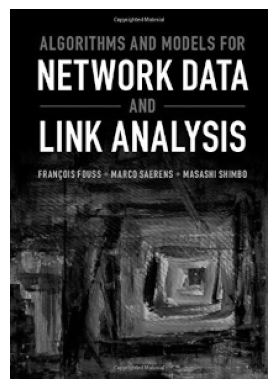

In [16]:
train = cv_grayread(f'{SOURCE}-train.png')

train_height, train_width = train.shape

cv_imshow(train)

## Loading and displaying the scene image

We will call this image `query` to be consistent with the OpenCV keypoint framework.

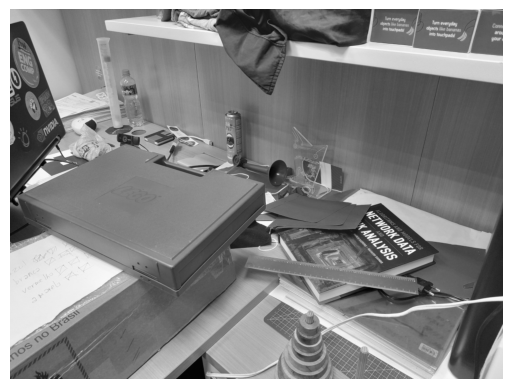

In [17]:
query = cv_grayread(f'{SOURCE}-query.png')

query_height, query_width = query.shape

cv_imshow(query)

## Extracting keypoints and descriptors

We will use the SIFT algorithm, which will be detailed in a later class.

The second parameter of the `detectAndCompute` method is a mask, in case you want to consider only a part of the image. Since we are considering the entire image, we will just leave it as `None`.

In [18]:
sift = cv.SIFT_create()

train_keypoints, train_descriptors = sift.detectAndCompute(train, None)
query_keypoints, query_descriptors = sift.detectAndCompute(query, None)

## Keypoint matching based on descriptor similarity

The [FLANN](https://github.com/flann-lib/flann) library provides fast algorithms and data structures for approximate nearest neighbor search.

The `knnMatch` method finds, for each scene descriptor, the `k` most similar object descriptors. To be consistent with the SIFT paper, we find the two nearest neighbors.

In [19]:
matcher = cv.FlannBasedMatcher()

matches = matcher.knnMatch(query_descriptors, train_descriptors, k=2)

However, we do not actually consider these two neighbors. The second is only used to evaluate the quality of the first, and the first is only used if its quality is acceptable.

If the first distance is above 80% of the second distance, both matches are discarded. Otherwise, only the second is discarded.

In [20]:
# A binary mask that we will need to
# avoid drawing the discarded matches.
matches_mask = []

# A list of the non-discarded matches.
good_matches = []

# Because we passed k=2 to knnMatch,
# each element is a tuple of size two.
for first, second in matches:

    # If the first distance is above 80% of
    # the second distance, both are discarded.
    if first.distance > 0.8 * second.distance:
        matches_mask.append((0, 0))

    # Otherwise, only the second is discarded.
    else:
        matches_mask.append((1, 0))
        good_matches.append(first)

The `drawMatchesKnn` method draws the keypoints and matches.

We can specify an output image as the last parameter, but, since one is not necessary we just leave it as `None`.

Because we pass `matches_mask`, the discarded matches are not drawn.

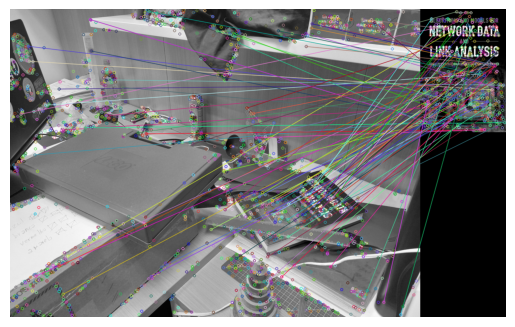

In [21]:
matches_output = cv.drawMatchesKnn(query, query_keypoints, train, train_keypoints, matches, None, matchesMask=matches_mask)

cv_imshow(matches_output)

## Estimating pose

The `findHomography` method estimates an homography based on a set of source points and a set of destination points. For each match, we add the object keypoint as source and the scene keypoint as destination.

The `cv.RANSAC` parameter is necessary for an estimation that is robust to outliers. The RANSAC algorithm will be detailed in a later class.

In [22]:
pose_src = []
pose_dst = []

for first in good_matches:
    pose_src.append(train_keypoints[first.trainIdx].pt)
    pose_dst.append(query_keypoints[first.queryIdx].pt)

# The findHomography method expects points
# given as NumPy arrays, so we need this.
pose_src = np.array(pose_src)
pose_dst = np.array(pose_dst)

# There are two outputs: the homography and
# a binary mask that indicates which matches
# are outliers with respect to it. We are
# not interested in this mask, so we use _.
H, _ = cv.findHomography(pose_src, pose_dst, cv.RANSAC)

To validate the homography, we will apply it to a rectangle around the object.

In [23]:
# The rectangle points must use the (x, y) ordering,
# because OpenCV really loves to make you confused.
rectangle_src = [
    (0, 0),
    (0, train_height),
    (train_width, train_height),
    (train_width, 0),
]

# OpenCV is also picky. The method expects a NumPy
# floating-point array and, due to some weirdness
# of the Python bindings, it also needs an extra
# dimension. This is why we wrap it in an extra [].
rectangle_src = np.array([rectangle_src], dtype=float)

# In a perfect world, this is the only line we
# would need. Alas, we sadly do not live in one.
rectangle_dst = cv.perspectiveTransform(rectangle_src, H)

# Reversing the pickiness. We use [0] to remove
# the extra dimension and a combination of round
# and astype to convert the points to integers.
rectangle_dst = rectangle_dst[0].round().astype(int)

Finally, we draw the transformed rectangle in the scene image.

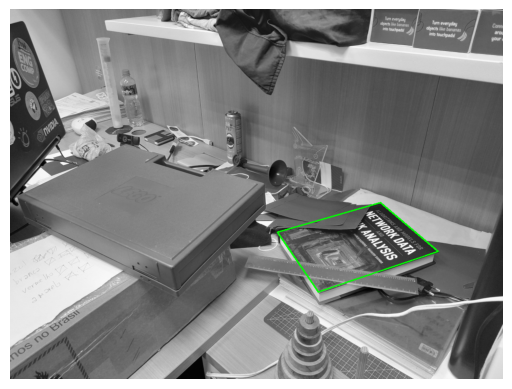

In [24]:
color = (0, 255, 0)

thickness = 2

rectangle_output = cv.cvtColor(query, cv.COLOR_GRAY2BGR)

cv.line(rectangle_output, rectangle_dst[0], rectangle_dst[1], color, thickness)
cv.line(rectangle_output, rectangle_dst[1], rectangle_dst[2], color, thickness)
cv.line(rectangle_output, rectangle_dst[2], rectangle_dst[3], color, thickness)
cv.line(rectangle_output, rectangle_dst[3], rectangle_dst[0], color, thickness)

cv_imshow(rectangle_output)

## Loading and displaying the original versions of the images

The outputs of the activities look much better in color, so we will load the original versions of both the object and scene.

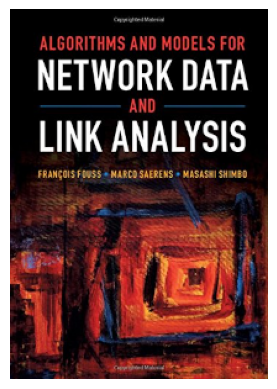

In [25]:
color_train = cv_imread(f'{SOURCE}-train.png')

cv_imshow(color_train)

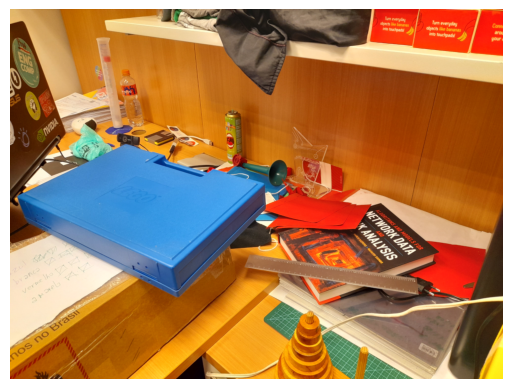

In [26]:
color_query = cv_imread(f'{SOURCE}-query.png')

cv_imshow(color_query)

## Activity 1: pose correction

1. Switch the `SOURCE` to `correction` and run the entire notebook again, up to this point.

2. Write code to **correct the pose of the printout in the scene image**.

For reference, [this image](https://drive.google.com/file/d/1m0RORpIdbsQdTAfREyGHwLFkh-6vUQX2/view?usp=sharing) shows the expected output.

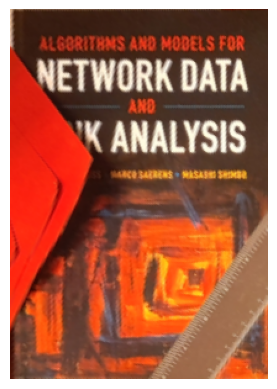

In [27]:
# What we want is to invert the effect of the homography.
# This can be achieved by literally inverting the matrix.

H1 = np.linalg.inv(H)

# Parameter 1: the image you want to transform.
#
# Parameter 2: the homography you want to apply.
#
# Parameter 3: the size of the output image. The
#              crop is from (0, 0) to this size.

train_size = (train_width, train_height)

output1 = cv.warpPerspective(color_query, H1, train_size)

cv_imshow(output1)

## Activity 2: augmented reality

For this activity, we will need an aditional image.

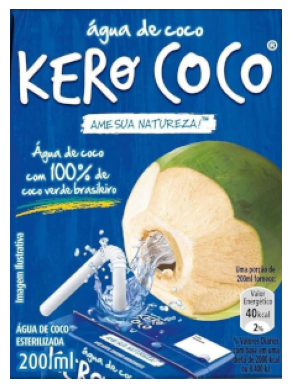

In [29]:
color_other = cv_imread('10/augmented-other.png')

other_height, other_width, _ = color_other.shape

cv_imshow(color_other)

1. Switch the `SOURCE` to `augmented` and run the entire notebook again, up to this point.

2. Write code to **replace the object occurence in the scene with the additional image**.

For reference, [this image](https://drive.google.com/file/d/1rg1Cab3tY36H7bVDptIaxGL6QSb7e129/view?usp=sharing) shows the expected output.

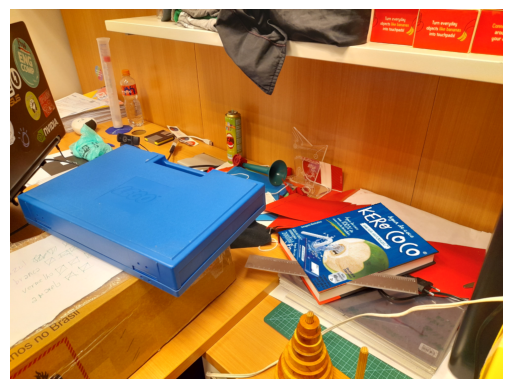

In [30]:
output2 = color_query.copy()

# Since the objects have very similar sizes, we
# could simply use the original homography H and
# the result would be reasonably good. However,
# for completeness, this code assumes that the
# two objects have considerably different sizes.

# First, build a rectangle around the new object.

rectangle_rev = [
    (0, 0),
    (0, other_height),
    (other_width, other_height),
    (other_width, 0),
]

rectangle_rev = np.array([rectangle_rev], dtype=float)

# Find an homography that maps this rectangle
# to the warped rectangle around the object.

H2, _ = cv.findHomography(rectangle_rev, rectangle_dst, cv.RANSAC)

# Here comes the tricky part: warpPerspective
# can do the entire job if you manage to find
# the correct, most up-to-date documentation.
#
# Parameter 1: the image you want to transform.
#
# Parameter 2: the homography you want to apply.
#
# Parameter 3: the size of the output image. The
#              crop is from (0, 0) to this size.
#
# Parameter 4: the background where you want to
#              overlay the transformed image.
#              (must be consistent with previous
#              parameter or will fail silently)
#
# Parameter 5: what do you want to do with the
#              points outside the limits of the
#              original image. The default is to
#              fill them with a solid color.

query_size = (query_width, query_height)

cv.warpPerspective(color_other, H2, query_size, output2, borderMode=cv.BORDER_TRANSPARENT)

cv_imshow(output2)

Alternatively, if you at least achieved the result below, you could manually implement the overlay by copying the non-black pixels.

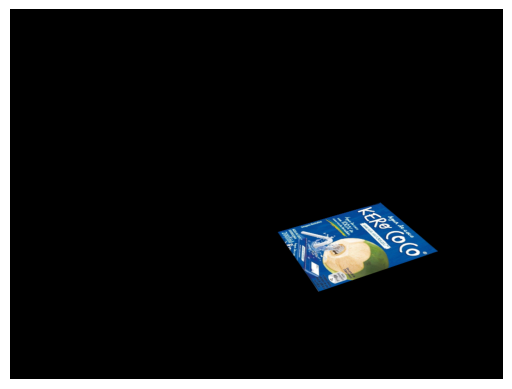

In [31]:
cv_imshow(cv.warpPerspective(color_other, H2, query_size, output2))

## Activity 3: panorama stitching

1. Switch the `SOURCE` to `panorama` and run the entire notebook again, up to this point.

2. Write code to **stitch the object and the scene together**.

For reference, [this image](https://drive.google.com/file/d/1enLkq0Xnxo_xz4nHIugSuRAh9RSSH07e/view?usp=sharing) shows the expected output.

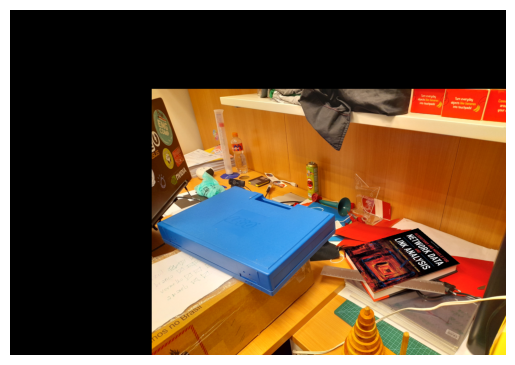

In [32]:
output3 = np.zeros((round(1.3 * query_height), round(1.4 * query_width), 3), dtype=np.uint8)

output3[-query_height:, -query_width:, :] = color_query

# First, build a rectangle that is a shifted
# version of the warped rectangle. Since the
# original scene was pasted in the lower right
# corner of the expanded scene, the shift is
# simply the difference of the dimensions.

height, width, _ = output3.shape

rectangle_mov = rectangle_dst.copy()
rectangle_mov[:, :1] += width - query_width
rectangle_mov[:, 1:] += height - query_height

# Find an homography that maps the original
# object rectangle to the shifted rectangle.

H3, _ = cv.findHomography(rectangle_src, rectangle_mov, cv.RANSAC)

# This is the same as we did in Activity 2.

size = (width, height)

cv.warpPerspective(color_train, H3, size, output3, borderMode=cv.BORDER_TRANSPARENT)

cv_imshow(output3)

You can click on the toc.png tab to the left to browse by section.